In [48]:
"""
Cet technique marche beaucoup mieux que dans tensorflow, avec en très peu de temps. 
Ce modèle fonctionne mieux que l'autre dans tensorflow parce qu'une raison évidente: 
il utilise méthode teacher forcing Un autre problème avec ce méthode, 
c'est dropout qui donne une technique plus ou moins bon. Il donne la 
réponse plus tôt aléatoire pour une question. En cas général, 
ce la peut être intéressant, mais dans notre cas, il est très important 
qu'il capture le mot clés 
(donc, surtout on risque de supprimer le mot clés, qui rendra une mauvais réponse)
modèle est bien entrainé, donc, il ne sert à rien d'entrainer encore.
hidden_size =45 tres mauvais; =70 bien; =100 tres bien; =120 très bien; =150 overfit.
hidden_size 50 20%
hidden_size 70 33%
hidden_size 120 28%
"""
#from IPython.display import display, Markdown
#display(Markdown("### Pour lancer un chat, il suffit de taper en même temps CTRL et ENTER"))
#display(Markdown("### Pour arrêter le mode chat, il suffit de taper ENTER dans votre conversation"))
%matplotlib inline

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import os

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F
import data
import config
import time
from dateparser.search import search_dates
import pandas as pd


use_cuda = torch.cuda.is_available()

hidden_size = 5
SOS_token  = config.SOS_token
EOS_token  = config.EOS_token
MAX_LENGTH = config.MAX_LENGTH
stopwords  = config.STOPWORDS
learning_rate = config.LEARNING_RATE
teacher_forcing_ratio = 0.2
dropout = config.DROPOUT

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def normalizeString(s):
    """
    Whith a tring s, we make it in lower case, delete \n if exists at 
    the end of string, and delete specical case ? . and !
    """
    s = s.lower().strip()
    s = re.sub(r"([,.!?\n])", r"", s)# sumprimer tous les caractères .! et ?
    #s = re.sub(r"[^a-zA-Z0-9.!?]+", r" ", s)
    return s


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH 

    
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(PAIRS):
    input_lang = Lang('question')
    output_lang = Lang( 'answer')
    pairs_trains, pairs_tests = [], []
   # index_train = random.sample(range(len(PAIRS)), int(len(PAIRS)*0.80))
    for i in range(len(PAIRS)):
        #if i in index_train:
            pairs_trains.append(PAIRS[i])
        #else:
            #pairs_tests.append(PAIRS[i])
    print("Read %s sentence pairs of training set" % len(pairs_trains))
    print("Read %s sentence pairs of test set" % len(pairs_tests))
    pairs_trains = filterPairs(pairs_trains)
    pairs_tests = filterPairs(pairs_tests)
    for i  in range(len(pairs_trains)) :
        pair = pairs_trains[i]
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    
    for i  in range(len(pairs_tests)) :
        pair = pairs_tests[i]
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs_trains, pairs_tests

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(EncoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result


class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1):
        super(DecoderRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        for i in range(self.n_layers):
            output = F.relu(output)
            output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if use_cuda:
            return result.cuda()
        else:
            return result
        

def normalizeSentenceInChat(sentence):
    sentence = sentence.strip().lower().split()
    s = [closetWord(word, input_lang) for word in sentence]
    return ' '.join(s)
        
        
            

def indexesFromSentence(lang, sentence):
    #sentence = normalizeSentence
    return [lang.word2index[word] for word in sentence.split(' ') if word in lang.word2index ]


def variableFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    result = Variable(torch.LongTensor(indexes).view(-1, 1))
    if use_cuda:
        return result.cuda()
    else:
        return result


def variablesFromPair(pair):
    input_variable = variableFromSentence(input_lang, pair[0])
    target_variable = variableFromSentence(output_lang, pair[1])
    return (input_variable, target_variable)


def train(input_variable, target_variable, encoder, decoder, 
          encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_variable.size()[0]
    target_length = target_variable.size()[0]

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_variable[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            loss += criterion(decoder_output, target_variable[di])
            decoder_input = target_variable[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            ni = topi[0][0]

            decoder_input = Variable(torch.LongTensor([[ni]]))
            decoder_input = decoder_input.cuda() if use_cuda else decoder_input

            loss += criterion(decoder_output, target_variable[di])
            if ni == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.data[0] / target_length

import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))
def get_skip_step(n_iters):
    return int(n_iters/10)

def trainIters(n_iters, encoder, decoder, plot_every=100, learning_rate=learning_rate):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    skip_step = get_skip_step(n_iters)
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [variablesFromPair(random.choice(pairs_trains))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_variable = training_pair[0]
        target_variable = training_pair[1]

        loss = train(input_variable, target_variable, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % skip_step == 0:
            print_loss_avg = print_loss_total / skip_step
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
    save_model(encoder, decoder)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    #sentence = normalizeSentenceInChat(sentence)
    input_variable = variableFromSentence(input_lang, sentence)
    input_length = input_variable.size()[0]
    encoder_hidden = encoder.initHidden()

    encoder_outputs = Variable(torch.zeros(max_length, encoder.hidden_size))
    encoder_outputs = encoder_outputs.cuda() if use_cuda else encoder_outputs

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_variable[ei],
                                                 encoder_hidden)
        encoder_outputs[ei] = encoder_outputs[ei] + encoder_output[0][0]

    decoder_input = Variable(torch.LongTensor([[SOS_token]]))  
    decoder_input = decoder_input.cuda() if use_cuda else decoder_input

    decoder_hidden = encoder_hidden

    decoded_words = []
    decoder_attentions = torch.zeros(max_length, max_length)

    for di in range(max_length):
        decoder_output, decoder_hidden = decoder(
            decoder_input, decoder_hidden)
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        ni = int(ni)
        if ni == EOS_token:
            #decoded_words.append('<EOS>')
            break
        else:
            decoded_words.append(output_lang.index2word[ni])

        decoder_input = Variable(torch.LongTensor([[ni]]))
        decoder_input = decoder_input.cuda() if use_cuda else decoder_input
    return decoded_words


def evaluate_randomly(encoder, decoder,n_iters=200, test=True):
    if not test:
        print('TEST error of word to word on TRAIN')
        list_print_random = random.sample(range(n_iters),20 )
        total_loss = 0
        for i in range(n_iters):
            pair = random.choice(pairs_trains)
            output_words = evaluate(encoder, decoder, pair[0])
            if 'EOS' in output_words:
                l = output_words.index('EOS')+1
            else:
                l = len(output_words)+1
            reponse = ' '.join(output_words[:l])
            loss = _evaluate_by_right_word(pair[1], reponse)
            total_loss +=loss
            if i in list_print_random:
                #answer = answers_with_data(pair[0], reponse)
                print('Question: ', pair[0])
                print('Réponse: ', pair[1])
                print('Bot: {}   ACCURACY {:.1f}'.format(reponse, 1-loss))
                #if answer != reponse:
                 #   print('Réponse avec data:', answer)                
                print('-'*50)
        print('Accuracy of good answer word to word: ', 1-total_loss/n_iters)
    else:
        n_iters = len(pairs_tests)
        total_loss = 0
        random_print_index = random.sample(range(n_iters), 20)
        for i in range(n_iters):
            pair = pairs_tests[i]
            output_words= evaluate(encoder, decoder, pair[0])
            if 'EOS' in output_words:
                l = output_words.index('EOS')+1
            else:
                l = len(output_words)+1
            reponse = ' '.join(output_words[:l])
            loss = _evaluate_by_right_word(pair[1], reponse)
            if i in random_print_index:
                print('Question: ', pair[0])
                print('Réponse: ', pair[1])
                print('Bot: {}. ACCURACY {:.1f}'.format(reponse, 1-loss))
                print('-'*50)
            total_loss +=loss
        print('Test on {}'.format(n_iters))
        print('Accuracy by percent of true words {}'.format(1-total_loss/n_iters))
 

                
def make_dir(path):
    """ Create a directory if there isn't one already. """
    try:
        os.mkdir(path)
    except OSError:
        pass


def chat(encoder, decoder):
    make_dir(config.CHECK_POINT_PATH)
    lines = construct_dict(input_lang)
    output_file = open(os.path.join(config.CHECK_POINT_PATH, 'convos70.txt'), 'a+')
    print('Bonjour, c\'est le Bot d\'AVICEN, Je peux vous aider? \n')
    while True:
            line = str(input('Vous: '))
            if len(line) > 0 and line[-1] == '\n':
                line = line[:-1]
            if line == '':
                break
            line = normalizeString(line)
            #transform_line  = normalizeSentenceInChat(line)
            #transform_line = find_close_line(lines, input_lang, transform_line)
            #print('LIGNE TRANFORMÉ: ', line)
            output_file.write('VOUS ++++ ' + line + '\n')
            reponse = evaluate(encoder, decoder, line)
            if 'SOS' in reponse:
                 reponse = reponse[1:] 
            if 'EOS' in reponse:
                reponse = reponse[:-1] 
            reponse = " ".join(reponse)
            output_file.write('BOT ++++ ' + reponse + '\n')
            print('Without Data: ', reponse)
            reponse = answers_with_data(line, reponse)
            print('Bot AVICEN: ', reponse)
            print('-'*50)
    output_file.close() 

if __name__=='__main__':
    try:
        input_lang0
    except NameError :
        pair1 = ['combien de voitures qui roulent', 'il y en a cing']
        pair2 = ['combien de véhicules à l\'arrêt', 'environ trois']
        PAIRS = [pair1, pair2]
        input_lang, output_lang, pairs_trains, pairs_tests = prepareData(PAIRS)
        encoder = EncoderRNN(input_lang.n_words, hidden_size)
        decoder = DecoderRNN(hidden_size, output_lang.n_words,1)

Read 2 sentence pairs of training set
Read 0 sentence pairs of test set
Counted words:
question 10
answer 9


In [45]:
chat()

Reading the parameters from check_point/encoder_test_semantique.ck and check_point/decoder_test_semantique.ck...
Bonjour, c'est le Bot d'AVICEN, Je peux vous aider? 

Vous: combien de voitures
Without Data:  il y en a cing
Bot AVICEN:  il y en a cing
--------------------------------------------------
Vous: combien de véhicules
Without Data:  il y en a cing
Bot AVICEN:  il y en a cing
--------------------------------------------------
Vous: combien véhicules qui roulent
Without Data:  il y en a cing
Bot AVICEN:  il y en a cing
--------------------------------------------------
Vous: combien voitures à l'arrêt
Without Data:  environ trois
Bot AVICEN:  environ trois
--------------------------------------------------
Vous: qui
Without Data:  il y en a cing
Bot AVICEN:  il y en a cing
--------------------------------------------------
Vous: à
Without Data:  environ trois
Bot AVICEN:  environ trois
--------------------------------------------------
Vous: voitures
Without Data:  il y en a cin

In [53]:
chat(encoder, decoder)

Bonjour, c'est le Bot d'AVICEN, Je peux vous aider? 

Vous: bonjour
Without Data:  environ trois
Bot AVICEN:  environ trois
--------------------------------------------------
Vous: combien de voitures roulent
Without Data:  il y en a cing
Bot AVICEN:  il y en a cing
--------------------------------------------------
Vous: combien de véhicules à l'arrêt
Without Data:  environ trois
Bot AVICEN:  environ trois
--------------------------------------------------
Vous: voitures à l'arrêt
Without Data:  environ trois
Bot AVICEN:  environ trois
--------------------------------------------------
Vous: véhicules roulent
Without Data:  il y en a
Bot AVICEN:  il y en a
--------------------------------------------------
Vous: combien véhicules qui roulent
Without Data:  il y en a cing
Bot AVICEN:  il y en a cing
--------------------------------------------------
Vous: 


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/ipykernel/__main__.py:298: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0m 4s (- 0m 38s) (1500 10%) 0.0067
0m 8s (- 0m 34s) (3000 20%) 0.0060
0m 12s (- 0m 29s) (4500 30%) 0.0054
0m 16s (- 0m 25s) (6000 40%) 0.0050
0m 21s (- 0m 21s) (7500 50%) 0.0046
0m 25s (- 0m 16s) (9000 60%) 0.0042
0m 29s (- 0m 12s) (10500 70%) 0.0040
0m 33s (- 0m 8s) (12000 80%) 0.0037
0m 37s (- 0m 4s) (13500 90%) 0.0035
0m 42s (- 0m 0s) (15000 100%) 0.0033


/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


<Figure size 432x288 with 0 Axes>

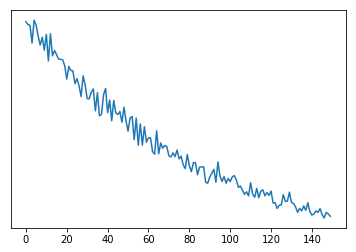

In [52]:
trainIters(15000,encoder, decoder)

In [25]:
chat()

Reading the parameters from check_point/encoder_test_semantique.ck and check_point/decoder_test_semantique.ck...
Bonjour, c'est le Bot d'AVICEN, Je peux vous aider? 

Vous: 


In [34]:
evaluate_randomly(test = False)

Reading the parameters from check_point/encoder_test_semantique.ck and check_point/decoder_test_semantique.ck...
TEST error of word to word on TRAIN
Question:  combien de véhicules à l'arrêt
Réponse:  environ trois
Bot: environ trois   ACCURACY 1.0
--------------------------------------------------
Question:  combien de véhicules à l'arrêt
Réponse:  environ trois
Bot: environ trois   ACCURACY 1.0
--------------------------------------------------
Question:  combien de véhicules à l'arrêt
Réponse:  environ trois
Bot: environ trois   ACCURACY 1.0
--------------------------------------------------
Question:  combien de véhicules à l'arrêt
Réponse:  environ trois
Bot: environ trois   ACCURACY 1.0
--------------------------------------------------
Question:  combien de véhicules à l'arrêt
Réponse:  environ trois
Bot: environ trois   ACCURACY 1.0
--------------------------------------------------
Question:  combien de véhicules à l'arrêt
Réponse:  environ trois
Bot: environ trois   ACCURACY 

In [11]:
chat()

Reading the parameters from check_point/encoder_simulation_2.ck and check_point/decoder_simulation_2.ck...
Bonjour, c'est le Bot d'AVICEN, Je peux vous aider? 

Vous: 
